# Preprocessing of BacDrop data

In [2]:
import scanpy as sc
import mudata as md
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scranPY
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

from scipy.sparse import csr_matrix

In [2]:
#import os
#os.environ["R_HOME"] = "C:\Program Files\R\R-4.3.2"

import rpy2.rinterface_lib.callbacks
from rpy2.robjects import pandas2ri
import anndata2ri

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

C:\Users\Jan\AppData\Local\Temp\ipykernel_13320\2632540109.py:6: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
path_nSBM = '../data/raw/mudata_nSBM_hierarchy_2.h5mu'
path_KEGG = '../data/raw/mudata_KEGG_hierarchy_2.h5mu'
path_phrog = '../data/raw/mudata_phrog_hierarchy_2.h5mu'

In [4]:
data_nSBM = md.read_h5mu(path_nSBM)
data_nSBM

MuData object with n_obs × n_vars = 437964 × 32110
  3 modalities
    SC_genes:	437964 x 13536
      obs:	'strains'
      var:	'strains', 'matchin_protein', 'protein'
      uns:	'genes_match', 'protein_match', 'unmatch_genes'
    SC_proteins:	437964 x 13090
      obs:	'strains'
      var:	'genes_mapping', 'strains'
      uns:	'Consensus_tree', 'protein_adjacency_matrix', 'protein_match', 'protein_unmatch'
      varm:	'protein_hierarchy'
    SC_PCs:	437964 x 5484
      obs:	'strains'
      var:	'PCs_match'
      uns:	'Consensus_tree_PCs', 'PCs', 'PCs_to_genes', 'PCs_unmatch', 'Purity_info', 'Purity_info_unique', 'protein_match'
      varm:	'protein_hierarchy_PCs'

In [5]:
data_gex = data_nSBM['SC_genes'].copy()
data_gex

AnnData object with n_obs × n_vars = 437964 × 13536
    obs: 'strains'
    var: 'strains', 'matchin_protein', 'protein'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'

### Removal of doublets and noise
Most of the cells express not more than ~250 genes per cell and are probably doublets, so they are removed

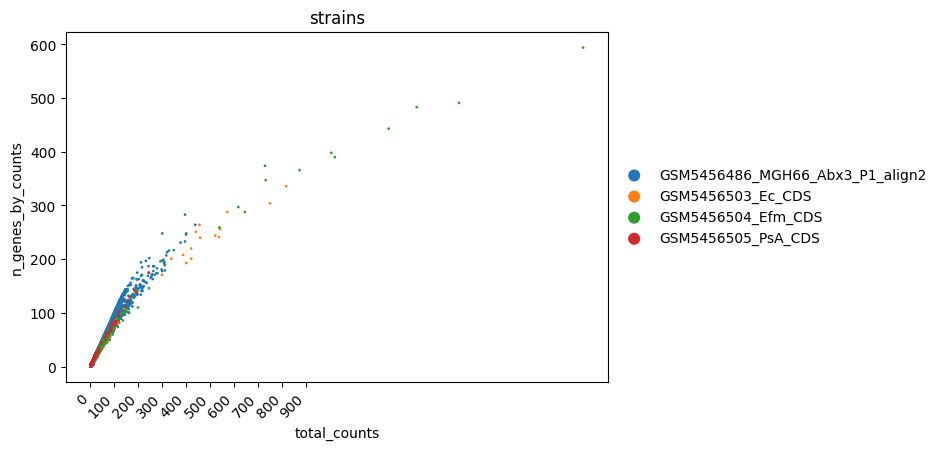

In [6]:
sc.pp.calculate_qc_metrics(data_gex, var_type="genes", percent_top=None, log1p=False, inplace=True)

g = sc.pl.scatter(data_gex, x='total_counts', y='n_genes_by_counts', color="strains", show=False, size=15)
g.set_xticks(ticks=range(0, 1000, 100))
g.set_xticklabels(labels=range(0, 1000, 100), rotation=45, ha="right")
plt.show()

In [8]:
print('Original data shape:\t\t', data_gex.shape)
sc.pp.filter_cells(data_gex, max_counts=250)
print('Shape after doublet removal:\t', data_gex.shape)

Original data shape:		 (437904, 13536)
Shape after doublet removal:	 (437904, 13536)


### Split strain specific into 4 datasets

In [112]:
print('Original data shape (n x p):\t', data_gex.shape)
print('--------------------------------------------------')

data_gex_mgh = data_gex[data_gex.obs['strains'] == 'GSM5456486_MGH66_Abx3_P1_align2'].copy()
print('Original mgh data shape:\t', data_gex_mgh.shape)
sc.pp.filter_genes(data_gex_mgh, min_cells=1)
sc.pp.calculate_qc_metrics(data_gex_mgh, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_mgh.shape)
print('--------------------------------------------------')


data_gex_efm = data_gex[data_gex.obs['strains'] == 'GSM5456504_Efm_CDS'].copy()
print('original efm data shape:\t', data_gex_efm.shape)
sc.pp.filter_genes(data_gex_efm, min_cells=1)
sc.pp.calculate_qc_metrics(data_gex_efm, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_efm.shape)
print('--------------------------------------------------')


data_gex_ec = data_gex[data_gex.obs['strains'] == 'GSM5456503_Ec_CDS'].copy()
print('original ec data shape:\t\t', data_gex_ec.shape)
sc.pp.filter_genes(data_gex_ec, min_cells=1)
sc.pp.calculate_qc_metrics(data_gex_ec, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_ec.shape)
print('--------------------------------------------------')


data_gex_psa = data_gex[data_gex.obs['strains'] == 'GSM5456505_PsA_CDS'].copy()
print('original psa data shape:\t', data_gex_psa.shape)
sc.pp.filter_genes(data_gex_psa, min_cells=1)
sc.pp.calculate_qc_metrics(data_gex_psa, var_type="genes", percent_top=None, log1p=False, inplace=True)
print('Strain specific genes shape:\t', data_gex_psa.shape)

Original data shape (n x p):	 (437904, 13536)
--------------------------------------------------
Original mgh data shape:	 (410110, 13536)
Strain specific genes shape:	 (410110, 4066)
--------------------------------------------------
original efm data shape:	 (9963, 13536)
Strain specific genes shape:	 (9963, 2337)
--------------------------------------------------
original ec data shape:		 (9639, 13536)
Strain specific genes shape:	 (9639, 3620)
--------------------------------------------------
original psa data shape:	 (8192, 13536)
Strain specific genes shape:	 (8192, 3478)


### TODO: Lower bound preprocessing

### Normalization & Variance stabilization

Several normalization methods and VSTs are applied and saved in different layers:
- Log1p normalization
- Scanpy's total sum normalization with target sum being median count
- Square root transformation
- Scran normalization (https://www.sc-best-practices.org/preprocessing_visualization/normalization.html & https://github.com/sfortma2/scranPY/blob/main/scranPY_tutorial.ipynb)

In [113]:
data_gex_ec.layers["log1p"] = sc.pp.log1p(data_gex_ec, copy=True).X
data_gex_ec.layers["sqrt_counts"] = np.sqrt(data_gex_ec.X)
data_gex_ec.layers["norm_counts"] = sc.pp.normalize_total(data_gex_ec, target_sum=None, inplace=False)['X']

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


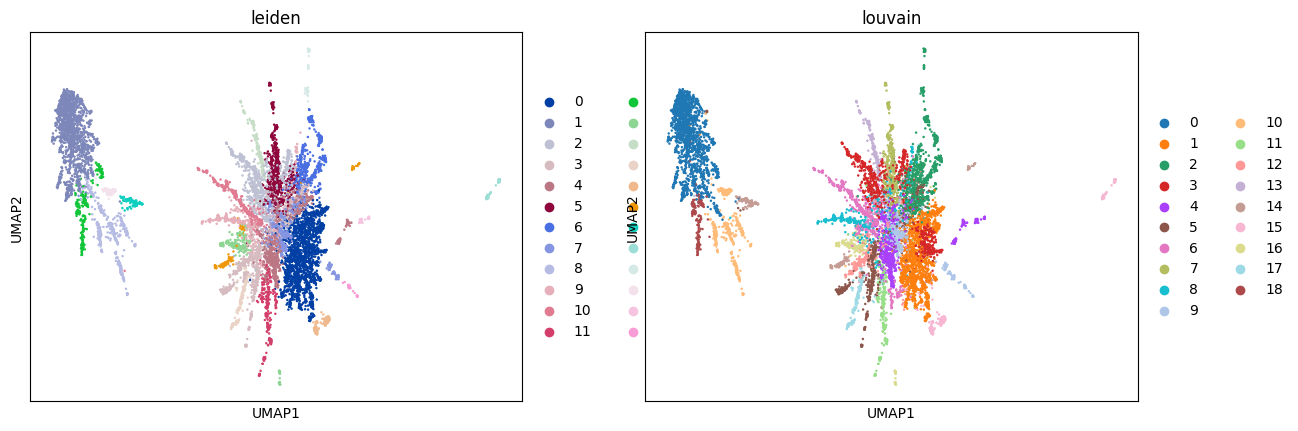

In [114]:
#Compute clusters for scran
data_gex_ec_pp = data_gex_ec.copy()

sc.pp.normalize_total(data_gex_ec_pp)
sc.pp.log1p(data_gex_ec_pp)
sc.pp.pca(data_gex_ec_pp, n_comps=15)
sc.pp.neighbors(data_gex_ec_pp, n_neighbors=80)
sc.tl.leiden(data_gex_ec_pp, resolution=0.5, key_added="leiden")
sc.tl.louvain(data_gex_ec_pp, key_added="louvain")

sc.tl.umap(data_gex_ec_pp)
sc.pl.umap(data_gex_ec_pp, color=["leiden", "louvain"])

In [115]:
data_gex_ec.obs["louvain"] = data_gex_ec_pp.obs["louvain"]
data_gex_ec.X = data_gex_ec.X.A
del(data_gex_ec_pp)

Current smallest cluster =  162  cells.
Using max_size =  3000 , clusters have been split into  19  clusters.
min_mean =  0.02


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\scranPY\main.py:171: RuntimeWarning: divide by zero encountered in divide
  rescaling[clust] = np.nanmedian(cur_prof / ref_prof)


--- 0.62 mins ---
size factor min =  0.0038110502240261764
size factor max =  24.36546895240509


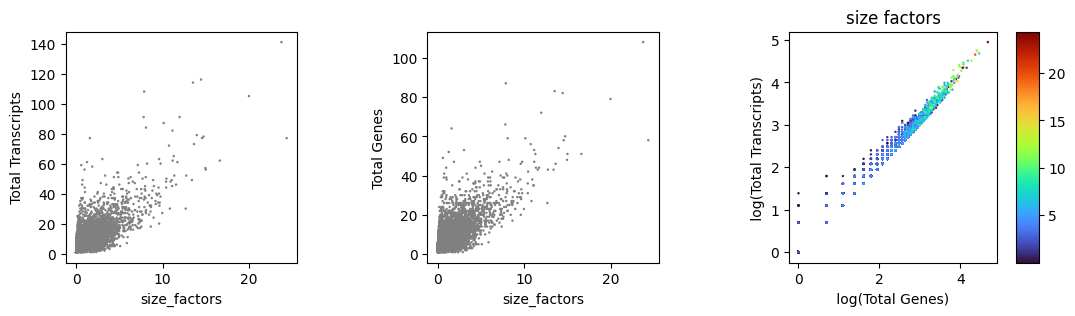

array([2.56750141, 1.46233405, 3.04041888, ..., 0.57121591, 1.42752895,
       3.28164902])

<Figure size 640x480 with 0 Axes>

In [116]:
scranPY.compute_sum_factors(data_gex_ec, clusters="louvain", parallelize=False, algorithm='CVXPY', 
   max_size=3000, min_mean=0.02, plotting=True, lower_bound=0.1, normalize_counts=False, log1p=False, layer='scranPY', 
   save_plots_dir=None, stopwatch=True)

In [117]:
#after scran matrix back to sparse
data_gex_ec.X = csr_matrix(data_gex_ec.X)

In [120]:
data_gex_ec.layers['scran_norm'] = sc.pp.log1p(data_gex_ec.X / data_gex_ec.obs.size_factors.to_numpy()[:, np.newaxis], copy=True)

Text(0.5, 0.98, 'E. Coli Normalization & VST')

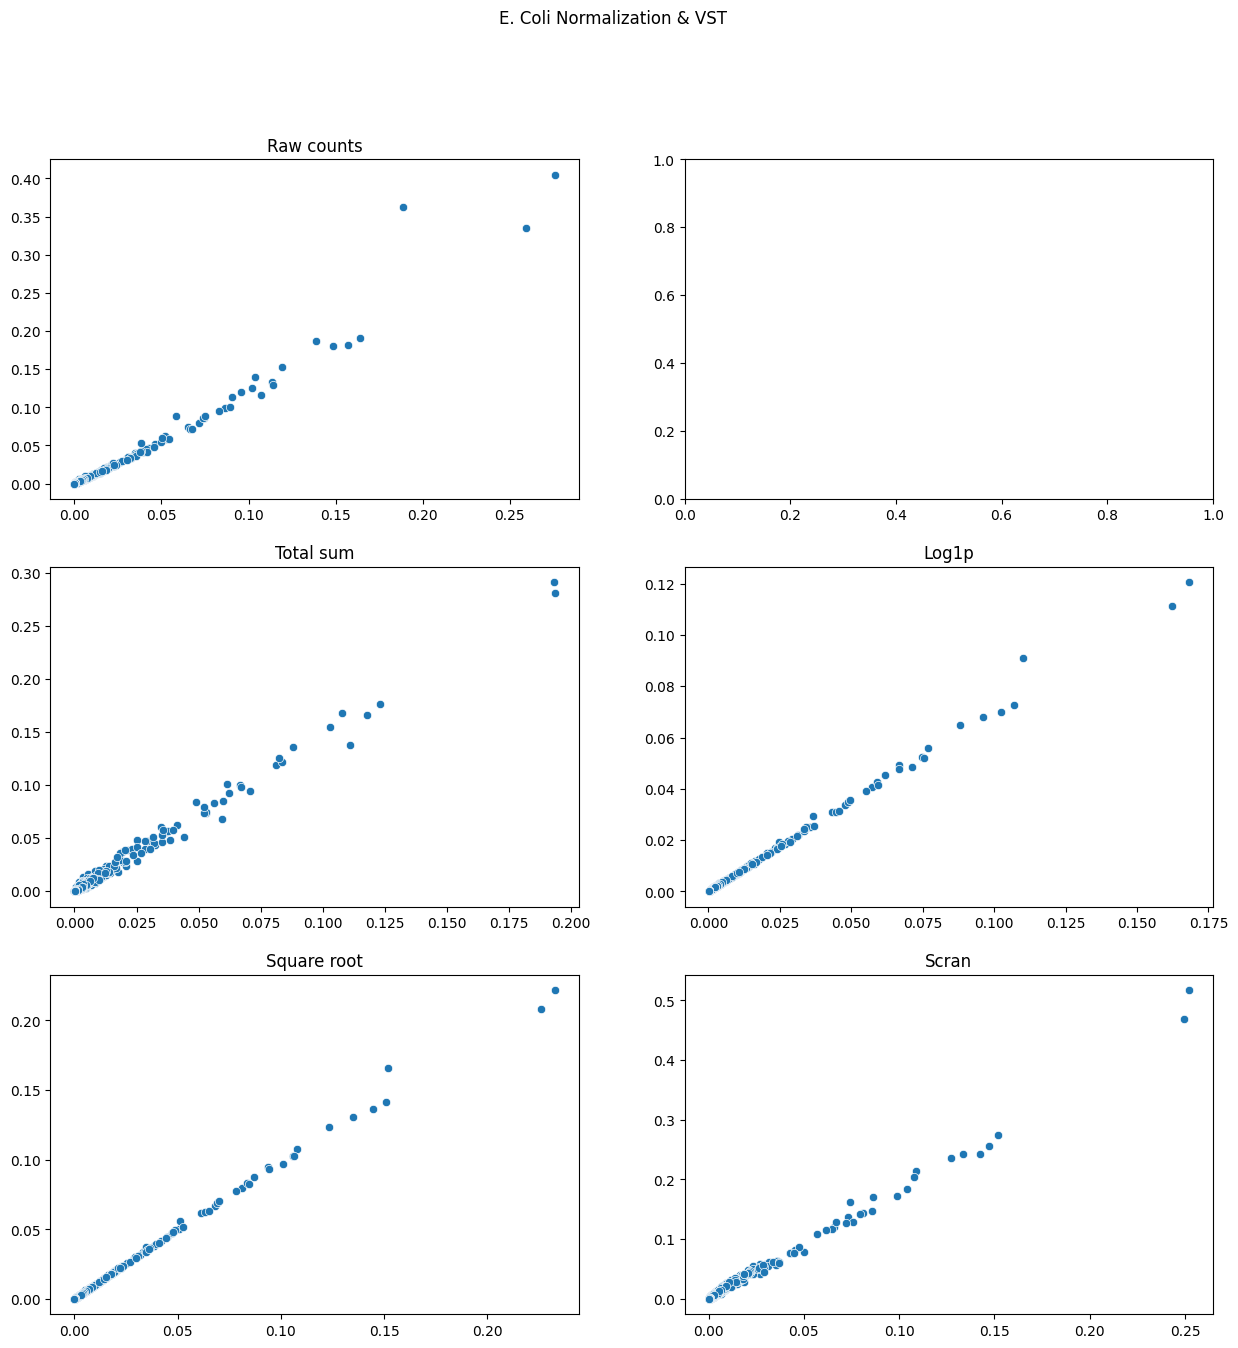

In [131]:
fig, axes = plt.subplots(3, 2, figsize=(15,15))

sns.scatterplot(x=np.mean(data_gex_ec.X.A, axis=0), y=np.var(data_gex_ec.X.A, axis=0), ax=axes[0][0])

sns.scatterplot(x=np.mean(data_gex_ec.layers['norm_counts'].A, axis=0), 
                y=np.var(data_gex_ec.layers['norm_counts'].A, axis=0), 
                ax=axes[1][0])

sns.scatterplot(x=np.mean(data_gex_ec.layers['log1p'].A, axis=0), 
                y=np.var(data_gex_ec.layers['log1p'].A, axis=0), 
                ax=axes[1][1])

sns.scatterplot(x=np.mean(data_gex_ec.layers['sqrt_counts'].A, axis=0), 
                y=np.var(data_gex_ec.layers['sqrt_counts'].A, axis=0), 
                ax=axes[2][0])

sns.scatterplot(x=np.mean(data_gex_ec.layers['scran_norm'].A, axis=0), 
                y=np.var(data_gex_ec.layers['scran_norm'].A, axis=0), 
                ax=axes[2][1])


axes[0,0].set_title("Raw counts")
axes[1,0].set_title("Total sum")
axes[1,1].set_title("Log1p")
axes[2,0].set_title("Square root")
axes[2,1].set_title("Scran")
fig.suptitle("E. Coli Normalization & VST")

In [7]:
print('original data shape:\t\t\t\t', data_gex.shape)
sc.pp.filter_cells(data_gex, min_genes=5)
print('remove cells that have less than 5 genes:\t', data_gex.shape)
sc.pp.filter_cells(data_gex, max_counts=250)
print('remove cells that have more than 250 genes:\t', data_gex.shape)

original data shape:				 (437964, 13536)
remove cells that have less than 5 genes:	 (293905, 13536)
remove cells that have more than 250 genes:	 (293845, 13536)


c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


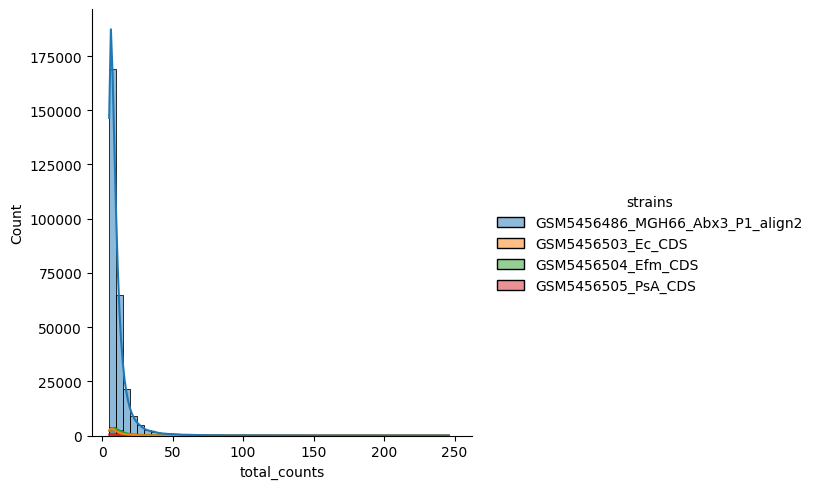

In [9]:
sns.displot(data_gex.obs, x="total_counts", binwidth=5, kde=True, hue="strains")
plt.show()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(


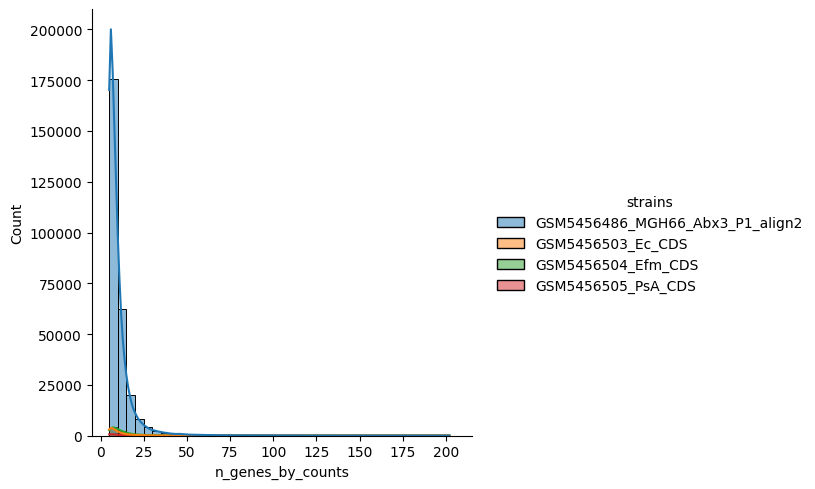

In [10]:
sns.displot(data_gex.obs, x="n_genes_by_counts", binwidth=5, kde=True, hue="strains")
plt.show()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of o

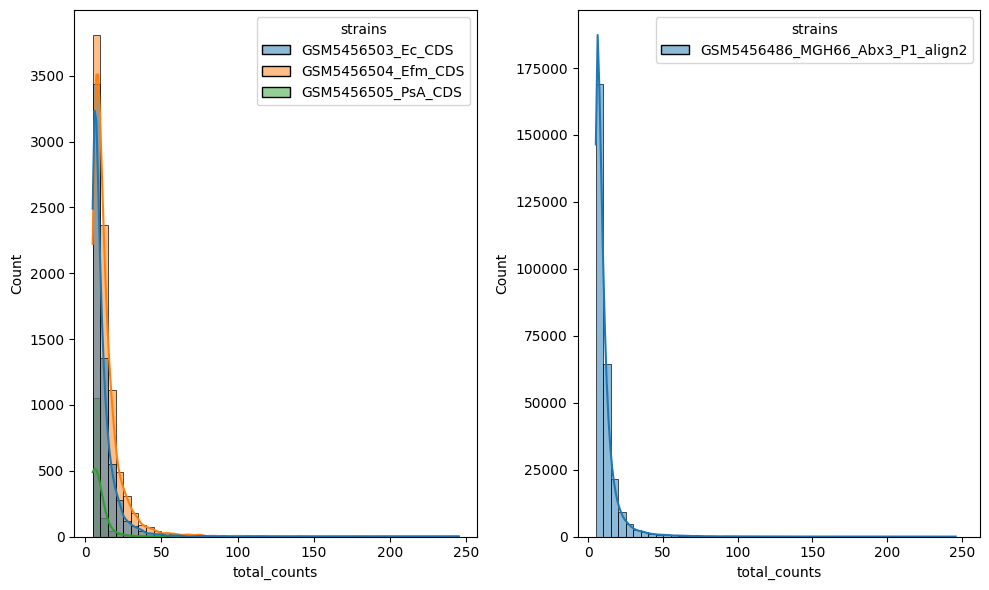

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
sns.histplot(data_gex[data_gex.obs["strains"] != "GSM5456486_MGH66_Abx3_P1_align2"].obs, x="total_counts", binwidth=5, kde=True, hue="strains", ax=axes[0])
sns.histplot(data_gex[data_gex.obs["strains"] == "GSM5456486_MGH66_Abx3_P1_align2"].obs, x="total_counts", binwidth=5, kde=True, hue="strains", ax=axes[1])
plt.tight_layout()
plt.show()

c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Jan\.conda\envs\bacdrop\lib\site-packages\seaborn\_oldcore.py:1057: FutureWarning: The default of o

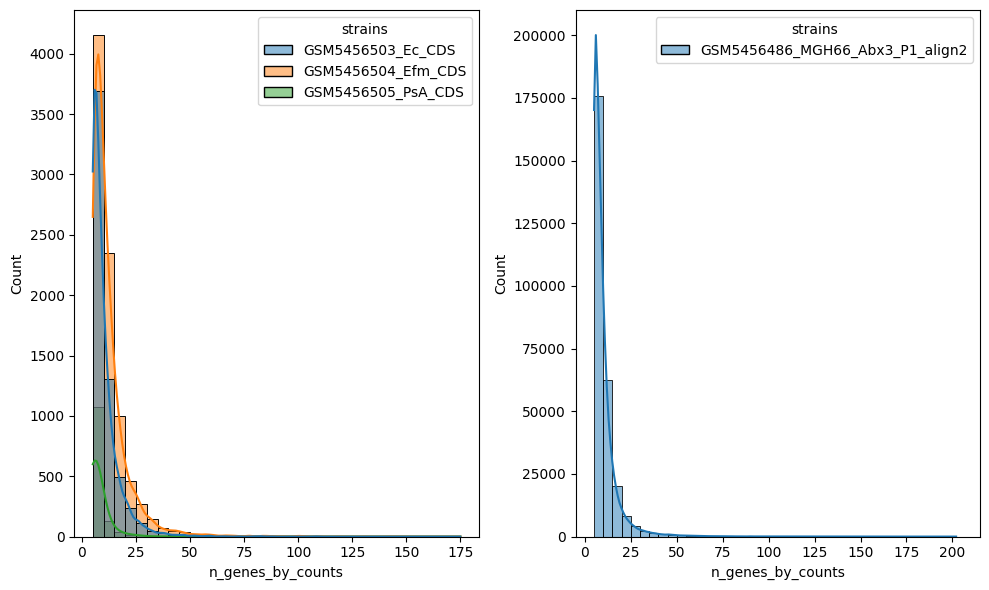

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(10,6))
sns.histplot(data_gex[data_gex.obs["strains"] != "GSM5456486_MGH66_Abx3_P1_align2"].obs, x="n_genes_by_counts", binwidth=5, kde=True, hue="strains", ax=axes[0])
sns.histplot(data_gex[data_gex.obs["strains"] == "GSM5456486_MGH66_Abx3_P1_align2"].obs, x="n_genes_by_counts", binwidth=5, kde=True, hue="strains", ax=axes[1])
plt.tight_layout()
plt.show()

In [24]:
data_gex_mgh

AnnData object with n_obs × n_vars = 277962 × 4031
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'sqrt_counts', 'norm_counts', 'sqrt_norm_counts'

In [25]:
data_gex_efm

AnnData object with n_obs × n_vars = 8613 × 2326
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'sqrt_counts', 'norm_counts', 'sqrt_norm_counts'

In [26]:
data_gex_ec

AnnData object with n_obs × n_vars = 5964 × 3379
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'sqrt_counts', 'norm_counts', 'sqrt_norm_counts'

In [27]:
data_gex_psa

AnnData object with n_obs × n_vars = 1306 × 2657
    obs: 'strains', 'n_genes_by_counts', 'total_counts', 'n_genes', 'n_counts'
    var: 'strains', 'matchin_protein', 'protein', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'var_counts', 'n_cells'
    uns: 'genes_match', 'protein_match', 'unmatch_genes'
    layers: 'counts', 'sqrt_counts', 'norm_counts', 'sqrt_norm_counts'

In [28]:
sc.write(filename='../data/preprocessed/mgh_prepro.h5ad', adata=data_gex_mgh)
sc.write(filename='../data/preprocessed/efm_prepro.h5ad', adata=data_gex_efm)
sc.write(filename='../data/preprocessed/ec_prepro.h5ad', adata=data_gex_ec)
sc.write(filename='../data/preprocessed/psa_prepro.h5ad', adata=data_gex_psa)